## Data Preparation

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


### Dataset Loading

In [2]:
patient = pd.read_csv("dataset/patient.csv")
diag = pd.read_csv("dataset/diagnosis.csv")
lab = pd.read_csv("./dataset/lab.csv")
admission = pd.read_csv("./dataset/admissionDx.csv")

### Data Cleaning

In [6]:
patient_with_my = admission[admission["admitdxname"].str.contains("myocardial")]
patient_ids = set(patient_with_my["patientunitstayid"])

print(f"Patients with myocardial: {len(patient_with_my)}")
patient_ami = patient.loc[patient["patientunitstayid"].isin(patient_ids)]
patient_ami_more_than_5_days = patient_ami.loc[(patient_ami["hospitaldischargeoffset"]-patient_ami["hospitaladmitoffset"])/24/60 >= 5]

ids_more_than_5_days = list(patient_ami_more_than_5_days["uniquepid"])
patient_alive_ami_uid = set(patient_ami_more_than_5_days["uniquepid"])

print(f"Patients with myocardial (5 days <= LOS): {len(patient_ami_more_than_5_days)}")
print(f"Patients Unqiue IDs: {len(patient_alive_ami_uid)}")

data = Counter(ids_more_than_5_days)
data_viz = dict()
for k,v in data.items():
    data_viz[v] = data_viz.get(v,0) + 1
print(f"Patients with 1 Visit: {data_viz[1]}")

patient_id_with1visit = set()
for k,v in data.items():
    if v == 1:
        patient_id_with1visit.add(k)

Patients with myocardial: 7231
Patients with myocardial (5 days <= LOS): 2034
Patients Unqiue IDs: 1929
Patients with 1 Visit: 1835


### Data Visualization

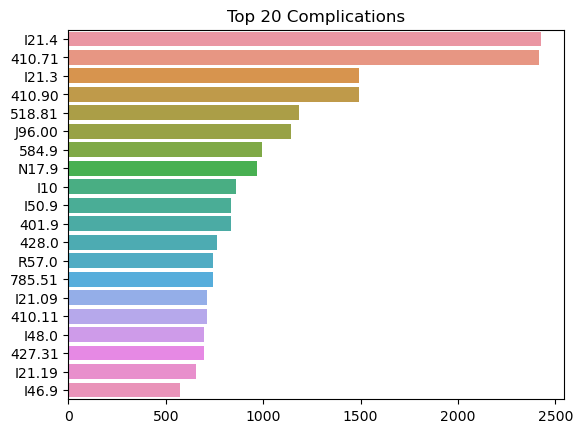

In [8]:
patient_with_1_visit = patient_ami_more_than_5_days.loc[patient_ami_more_than_5_days["uniquepid"].isin(patient_id_with1visit)]
icd_1_visit = diag.loc[diag["patientunitstayid"].isin(set(patient_with_1_visit["patientunitstayid"]))]

icd_codes = icd_1_visit["icd9code"].str.split(",", expand = True)

for i in range(6):
    icd_codes[i] = icd_codes[i].str.strip()

res = []
for row in icd_codes.values.tolist():
    res.extend(row)

data = dict(Counter(res))
sorted_data = []
for k,v in data.items():
    sorted_data.append(tuple((v,k)))

sorted_data.sort(reverse=True)
top = 20 + 2
ax = sns.barplot(x = [ele[0] for ele in sorted_data[2:top]], y = [ele[1] for ele in sorted_data[2:top]])
plt.title("Top 20 Complications")
plt.show()

### Target Vairables

In [19]:
def binary(tar, x):
    for ele in tar:
        if ele in x:
            return True
    return False

In [21]:
heart_problems = ['I50.9', 'I46.9', '427.5', '427.31', '428.0', '410.71', '410.9', '785.51', 'I48.0', 'I21.4', 'I21.3', 'R57.0']
lung_problem = ["518.81", "J96", "N17.9"]
lung_infection = ["486", "J18.9"]
kidney_problems = ["584.9"]

cur_patientunitstayid = patient_with_1_visit["patientunitstayid"]
cur_diag = diag.loc[diag["patientunitstayid"].isin(set(patient_with_1_visit["patientunitstayid"]))]

cur_diag["heart_problems"] = cur_diag["icd9code"].apply(lambda x: binary(heart_problems, str(x)))
cur_diag["lung_problem"] = cur_diag["icd9code"].apply(lambda x: binary(lung_problem, str(x)))
cur_diag["lung_infection"] = cur_diag["icd9code"].apply(lambda x: binary(lung_infection, str(x)))
cur_diag["kidney_problems"] = cur_diag["icd9code"].apply(lambda x: binary(kidney_problems, str(x)))

final_df = cur_diag.groupby("patientunitstayid").sum()
final_df["heart_problems"] = final_df["heart_problems"] > 0
final_df["lung_problem"] = final_df["lung_problem"] > 0
final_df["lung_infection"] = final_df["lung_infection"] > 0
final_df["kidney_problems"] = final_df["kidney_problems"] > 0

print(final_df["heart_problems"].value_counts())
print(final_df["lung_problem"].value_counts())
print(final_df["lung_infection"].value_counts())
print(final_df["kidney_problems"].value_counts())
final_df

29076
True     1310
False     468
Name: heart_problems, dtype: int64
False    1386
True      392
Name: lung_problem, dtype: int64
False    1668
True      110
Name: lung_infection, dtype: int64
False    1574
True      204
Name: kidney_problems, dtype: int64


/var/folders/0g/n9ssbxl556z_rblk_y0g59cm0000gn/T/ipykernel_2992/162449667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_diag["heart_problems"] = cur_diag["icd9code"].apply(lambda x: binary(heart_problems, str(x)))
/var/folders/0g/n9ssbxl556z_rblk_y0g59cm0000gn/T/ipykernel_2992/162449667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_diag["lung_problem"] = cur_diag["icd9code"].apply(lambda x: binary(lung_problem, str(x)))
/var/folders/0g/n9ssbxl556z_rblk_y0g59cm0000gn/T/ipykernel_2992/162

,diagnosisid,activeupondischarge,diagnosisoffset,heart_problems,lung_problem,lung_infection,kidney_problems
patientunitstayid,,,,,,,
141894,58790445,0,23711,True,True,True,True
142141,10800976,3,48,True,False,False,False
143646,31655175,8,120,True,False,False,False
144252,28871995,4,5144,False,False,False,False
144944,11553420,3,30,True,False,False,False
...,...,...,...,...,...,...,...
3352069,46326333,0,164,False,False,False,False
3352231,46097587,0,117,True,False,False,False
3352440,276846158,0,3404,True,True,False,True
